In [1]:
#import necessary packages
from astropy.io import ascii 
from astropy.table import Table
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.cosmology import WMAP9 as cosmo
from astropy.modeling import models, fitting
import os
import pickle
from tqdm import tqdm

In [2]:
#total catalog from COSMOS(2016)
total = Table.read('./datas/cosmos2015_2.fits')
#mass complete sample
total_z = total[(total['zphot'] > 0) & (total['zphot'] < 9) & (total['OType'] == 0) & (total['Mass'] > 9.545)]

# check photometric redshift reliability

In [3]:
# zCOSMOS + Silverman + VUDS + DEIMOS10k
master = Table.read('./datas/master_specz')
masterz = master[master['zphot'] > 0.0001]

(array([132., 127., 148., 174.,  37.,  11.,   6.,   3.,   2.,   3.]),
 array([0.        , 0.26700002, 0.53400004, 0.801     , 1.0680001 ,
        1.335     , 1.602     , 1.8690001 , 2.1360002 , 2.403     ,
        2.67      ], dtype=float32),
 [<matplotlib.patches.Polygon at 0x7fe99ce12950>])

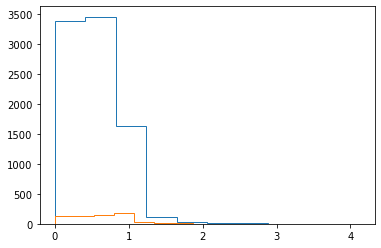

In [6]:
plt.hist(masterz['z_1'], histtype = 'step')
plt.hist(masterz['zspec_1'], histtype = 'step')

In [8]:
# all spectroscopic redshifts
speczs = []

for i in range(len(masterz)):
    
    if masterz['z_1'][i] > 0.01:
        speczs.append(masterz['z_1'][i])
    else:
        speczs.append(masterz['zspec_1'][i])
        
speczs = np.array(speczs) #8655

In [13]:
photz = masterz['zphot']
specz = masterz['z_1']

In [14]:
meds = []
disp = []
for i in np.arange(0.1, 1.3, 0.05):
    
    zmask = (photz > i - 0.2) & (photz < i + 0.2)
    
    phot = photz[zmask]
    spec = specz[zmask]
    
    diff = np.abs(phot - spec)
    sigma = diff / (1 + spec)
    
    med = np.median(sigma)
    meds.append(med)
    
    space = np.arange(0.005, 0.012, 0.001)
    
    sigmas = []
    
    for j in space:
        smask = (sigma > j) & (sigma < j + 0.001)
        ss = sigma[smask]
        
        sigmas.append(len(ss))
    
    disp.append(sigmas)

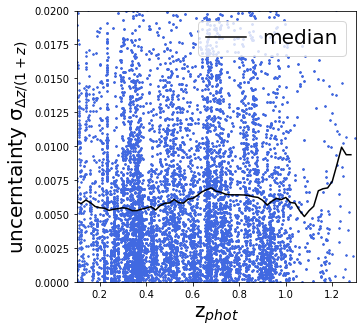

In [15]:
median = []
stds = []

phots = []
diffs = []

for i in np.arange(0.1, 1.3, 0.02):
    mask = (masterz['zphot'] >= i - 0.2) & (masterz['zphot'] < i + 0.2)
    sample = masterz[mask]
    
    photz = sample['zphot']
    specz = speczs[mask]
    
    diff = np.abs(photz - specz) / (1 + specz)
    med_diff = np.nanmedian(diff)

    std_diff = np.std(diff)
    
    phots.extend(photz.tolist())
    diffs.extend(diff.tolist())
    
    median.append(med_diff)
    stds.append(std_diff)

one_sigma = [x + y for x, y in zip(meds, stds)]

plt.figure(figsize = (5,5))
plt.plot(np.arange(0.1, 1.3, 0.02), median,  color = 'black', label = 'median')
# plt.fill_between(np.arange(0.1, 1.32, 0.02), meds[5:-15], one_sigma[5:-15], color = 'grey', alpha = .25)
plt.scatter(phots, diffs, s = 1, color = 'royalblue', alpha = .3)

plt.xlabel('z$_{phot}$', fontsize = 20)
plt.ylabel('uncerntainty σ$_{Δz/(1+z)}$', fontsize = 20)
plt.ylim(0.000, 0.02)
plt.xlim(0.1, 1.3)

plt.legend(fontsize = 20)
# plt.savefig('zphot_accuracy.png', bbox_inches = 'tight')

In [17]:
df = pd.DataFrame(disp, columns = np.arange(0.005, 0.012, 0.001), index = np.arange(0.1, 1.3, 0.05))
df = df.T
# df = df.loc[::-1]

In [20]:
cols = list(df.columns)
cols = [f'{x:.2f}' for x in cols]

ind =list(df.index)
ind = [f'{x:.3f}' for x in ind]

In [22]:
median = np.array(median)

(2.0, 22.0)

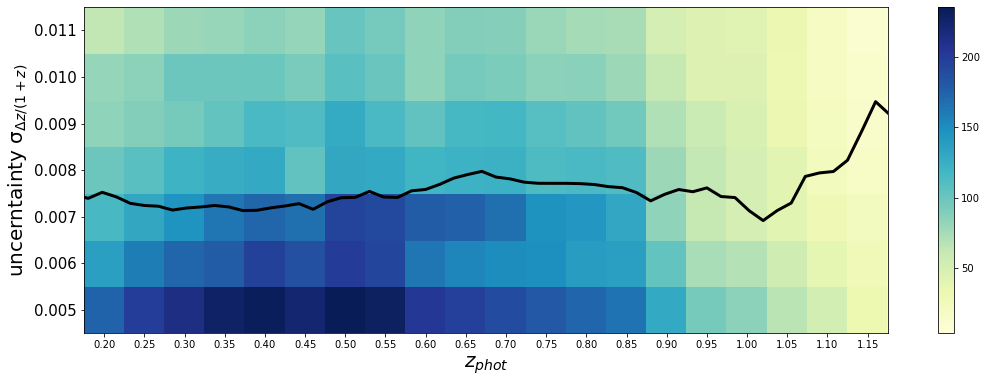

In [23]:
plt.figure(figsize = (18, 6))
bar = plt.pcolor(df.values, cmap='YlGnBu')
plt.colorbar(bar)
plt.xticks(np.arange(len(df.columns)) + 0.5, cols,fontsize = 10 )
plt.yticks(np.arange(len(df.index)) + 0.5, ind, fontsize = 15)
plt.plot(np.arange(0.1, 1.3, 0.02) * 420 / 24, median * 500,  color = 'black', linewidth = 3)

plt.xlabel('$z_{phot}$', fontsize = 20)
plt.ylabel('uncerntainty σ$_{Δz/(1+z)}$', fontsize = 20)

plt.xlim(2, 22)
# plt.savefig('photz-uncertainties.png')

Text(0, 0.5, 'uncerntainty σ$_{Δz/(1+z)}$')

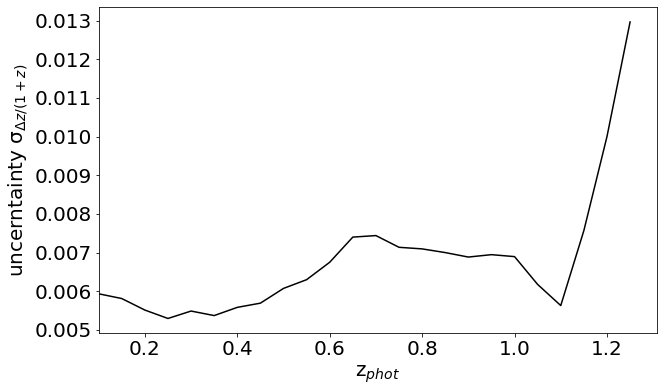

In [177]:
# meds
plt.figure(figsize = (10, 6))
plt.plot(np.arange(0.1, 1.3, 0.05), meds, color = 'black')
plt.xlim(0.1, )

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel('z$_{phot}$', fontsize = 20)
plt.ylabel('uncerntainty σ$_{Δz/(1+z)}$', fontsize = 20)

# find mass complete sample

In [27]:
#total catalog from COSMOS(2016)
total = Table.read('./datas/cosmos2015_2.fits')
total = total.to_pandas()
#mass complete sample
# total_z = total[(total['zphot'] > 0) & (total['zphot'] < 9) & (total['OType'] == 0) & (total['Mass'] > 9.545)]

In [28]:
#crossmatched with catalog2016 & zcosmos data
total_all = Table.read('./datas/cosmos2015.fits')
total_all = total_all[(total_all['zphot'] > 0) & (total_all['zphot'] < 2) & (total_all['OType'] == 0) & (total_all['Kswmag'] < 50)]
total_all = total_all.to_pandas()

len(total_all) # 331k for having Ks mag

331029

In [ ]:
phots = []
cms = []

for i in np.arange(0.1, 1.25, 0.05):
    #len = 1030, dataframe
    sample = total_all[(total_all['OType'] == 0) & (total_all['zphot'] >= i - 0.2) & (total_all['zphot'] < i + 0.2)]
    
    #calculate limiting mass
    m_limit = sample['Mass'] + 0.4 * (sample['Kswmag'] - 24)
    
    mask = sample['Mass'] > m_limit
#     print(len(sample[mask]) / len(sample))


    m_limit = m_limit.sort_values()
    m_index = int(len(m_limit) * 0.9)
    critical_mass = m_limit.iloc[m_index]
    print(critical_mass)

    phots.append(i)
    cms.append(critical_mass)
    
# critical_mass = 9.516

(6.0, 12.0)

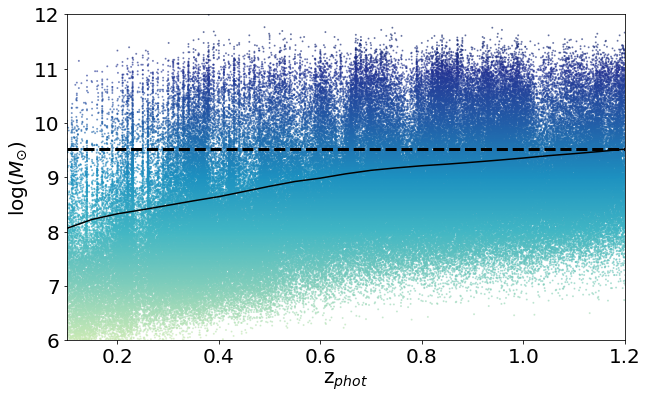

In [35]:
plt.figure(figsize = (10, 6))
plt.scatter(total_all['zphot'], total_all['Mass'], s = 1, alpha = .5, c = total_all['Mass'], cmap='YlGnBu')
# plt.colorbar()
# phots
plt.plot(phots, cms, color = 'black')
# plt.plot(phots, q_masses, color = 'red')
plt.xlim(0.1, 1.2)

plt.axhline(y = max(cms), color = 'black', linewidth = 3, linestyle = '--')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel('z$_{phot}$', fontsize = 20)
plt.ylabel(r'log($M_{\odot}$)', fontsize = 20)
plt.ylim(6, 12)

# plt.savefig('mass_complete.png', bbox_inches = 'tight')
# max(masses) #max mass = 9.54576 ~ 9.6

In [36]:
mask = total_all['Mass'] > max(cms)

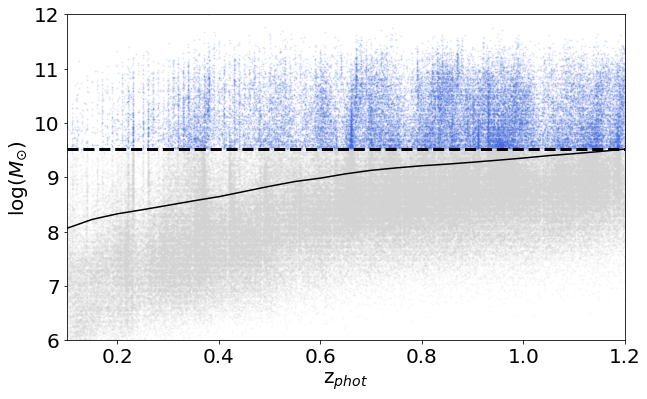

In [49]:
plt.figure(figsize = (10, 6))
plt.scatter(total_all[mask]['zphot'], total_all[mask]['Mass'], s = 1, alpha = .1, color = 'royalblue')
plt.scatter(total_all[~mask]['zphot'], total_all[~mask]['Mass'], s = 1, alpha = .1, color = 'lightgrey')
# plt.colorbar()
# phots
plt.plot(phots, cms, color = 'black')
# plt.plot(phots, q_masses, color = 'red')
plt.xlim(0.1, 1.2)

plt.axhline(y = max(cms), color = 'black', linewidth = 3, linestyle = '--')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel('z$_{phot}$', fontsize = 20)
plt.ylabel(r'log($M_{\odot}$)', fontsize = 20)
plt.ylim(6, 12)

plt.savefig('mass_complete.png', bbox_inches = 'tight')
# max(masses) #max mass = 9.54576 ~ 9.6